In [ ]:
#!pip install langgraph==0.2.59 langchain-core==0.3.25 langchain-community==0.3.12 openai==1.56.1

In [46]:
import warnings
warnings.filterwarnings('ignore')

import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from openai import AzureOpenAI
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

load_dotenv()

True

In [47]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
model = AzureOpenAI(
    azure_endpoint=os.getenv('AZURE_ENDPOINT'),
    api_key=os.getenv('AZURE_API_KEY'),
    api_version=os.getenv('AZURE_API_VERSION'),
)


In [48]:
class AgentState(TypedDict):
    topic: str
    planned: str
    writing: str
    reflect: List[str]
    accepted: bool
    revision: int
    max_revision: int
    tokens: int

In [55]:
# Função do Agente 1: Planeja conteúdo
def planner_node(state: AgentState):
    role_prompt = """
    Você agora é um planejador de blog experiente, com anos de atuação e um vasto repertório de habilidades. 
    Domina a arte da escrita e da edição, além de entender profundamente estratégias digitais e práticas de SEO. 
    Com sua capacidade de transformar ideias em conteúdos envolventes, você conhece as necessidades do público-alvo e mantém um tom editorial consistente. 
    É um líder nato, coordenando equipes de redatores, revisando textos com atenção aos detalhes e gerenciando cronogramas com eficiência. 
    Além disso, você antecipa tendências do mercado e utiliza ferramentas analíticas para garantir que o conteúdo entregue resultados, engajando leitores 
    e atingindo objetivos estratégicos.
"""
    instruction = f"Planeje conteúdo envolvente e factualmente preciso sobre:\n{state['topic']}\n"
    chat_prompt = [
      {"role": "system", "content": role_prompt},
      {"role": "user", "content": instruction}
    ]
    completion = model.chat.completions.create(
      model="gpt-4o-mini",
      messages=chat_prompt,
      # past_messages=10,
      max_tokens=800,
      temperature=0.7,
      top_p=0.95,
      frequency_penalty=0,
      presence_penalty=0,
      stop=None,
      stream=False
    )
    response = completion.choices[0].message
    total_tokens = completion.usage.total_tokens
    print('############## planner_node ############')
    print(response.content.strip())
    print(f"Tokens usados: {total_tokens}")  
    return {"planned": response.content.strip(), "tokens": state['tokens'] + total_tokens}

# Função do Agente 2: Escritor do blog
def writer_node(state: AgentState):
    role_prompt = f"""
                Você agora é um escritor de blog experiente, trabalhando em um novo artigo de opinião para o Medium. 
                Com anos de prática, você entende que a chave para criar conteúdo impactante é seguir as diretrizes do Planejador de conteúdo: \n{state['planned']}\n, 
                mas também adicionar sua própria análise crítica e insights imparciais. Baseando-se no esboço fornecido, 
                você explora o tema com profundidade, alinhando-se aos objetivos principais e à direção do artigo. 
                Seu texto é fundamentado em dados e informações objetivas, cuidadosamente extraídas do Planejador de conteúdo, 
                mas você também se assegura de identificar claramente quando suas afirmações são opiniões, distinguindo-as das conclusões baseadas em fatos. 
                Sua escrita é envolvente e confiável, oferecendo ao leitor uma perspectiva equilibrada e informada sobre o assunto..
"""
    instruction = f"Escreva perspicaz e factualmente preciso artigo de opinião sobre o tema: \n{state['topic']}\n"
    if len(state['reflect']) > 0:
        instruction += f"Considere os seguintes feedbacks:\n{chr(10).join(state['reflect'])}\n"
    chat_prompt = [
      {"role": "system", "content": role_prompt},
      {"role": "user", "content": instruction}
    ]
    completion = model.chat.completions.create(
      model="gpt-4o-mini",
      messages=chat_prompt,
      # past_messages=10,
      max_tokens=800,
      temperature=0.7,
      top_p=0.95,
      frequency_penalty=0,
      presence_penalty=0,
      stop=None,
      stream=False
    )
    response = completion.choices[0].message
    total_tokens = completion.usage.total_tokens
    
    print('\n\n')
    print('############## writer_node ############')
    print(response.content.strip())
    print(f"reflexões: {state['reflect']}")  
    print(f"Revisões: {state['revision']}")  
    print(f"Tokens usados: {total_tokens}")  
    return {"writing": response.content.strip(), "tokens": state['tokens'] + total_tokens}

# Função do Agente 3: Editor de blog
def editor_node(state: AgentState):
    role_prompt = """
    Você agora é um editor de blog experiente, com muitos anos de atuação, e possui uma atenção excepcional aos detalhes, além de um profundo entendimento das 
    nuances da escrita digital. Sua expertise vai além da correção gramatical e ortográfica, abrangendo a estruturação do texto, 
    o fluxo de ideias e a consistência do tom editorial. Você é capaz de identificar e corrigir incoerências, melhorar a clareza e a concisão, 
    além de garantir que o conteúdo esteja alinhado com as diretrizes de SEO. Com uma visão crítica e imparcial, você verifica a precisão das informações, 
    assegurando que o texto seja não apenas bem escrito, mas também informativo e confiável. Sua experiência permite detectar problemas sutis que poderiam 
    passar despercebidos por outros, garantindo que o conteúdo final seja de alta qualidade e atenda aos padrões exigidos pelo blog.
"""
    instruction = f"Com base no seguinte texto do escritor:\n{state['writing']}\n"
    instruction += f"""
R                       analisar um texto para blog é uma etapa essencial para garantir que o conteúdo seja claro, preciso e envolvente. 
                        Aqui estão algumas instruções para realizar uma revisão eficaz:

                    1.  Leia o texto de forma completa: Leia o texto inteiro para entender a fluidez e a coerência das ideias. 
                        Verifique se o conteúdo segue uma linha lógica e se cada seção contribui para o tema central.

                    2. Verifique a clareza e a concisão: Certifique-se de que o texto seja claro e direto. O conteúdo deve ser informativo sem ser excessivamente 
                       longo ou complexo.

                    3. Atenção à gramática e ortografia: Erros gramaticais, ortográficos e de pontuação. 
                       O uso correto da língua é fundamental para garantir que o texto seja profissional e fácil de entender.

                    4. Certifique-se de que ele esteja bem organizado, com parágrafos curtos e subtítulos que dividam o conteúdo em seções claras. 
                       A leitura deve ser fluída e fácil de seguir.

                    5. Verifique a relevância e o foco: Verifique se todas as partes do texto estão alinhadas com o tema principal {state['topic']}  e se contribuem para o objetivo do artigo.

                    6. Examine a introdução e a conclusão: A introdução deve atrair a atenção do leitor, e a conclusão deve resumir o conteúdo e, se necessário, incluir uma chamada à ação. Ambas devem ser claras e eficazes.
"""
    instruction += "Responda 'ACEITO' se o texto escrito estiver aderente ou 'REJEITADO' se não estiver.\n"
    chat_prompt = [
      {"role": "system", "content": role_prompt},
      {"role": "user", "content": instruction}
    ]
    completion = model.chat.completions.create(
      model="gpt-4o-mini",
      messages=chat_prompt,
      # past_messages=10,
      max_tokens=800,
      temperature=0.7,
      top_p=0.95,
      frequency_penalty=0,
      presence_penalty=0,
      stop=None,
      stream=False
    )
    response = completion.choices[0].message
    total_tokens = completion.usage.total_tokens
    
    print('\n\n')
    print('############## editor_node ############')
    print(response.content.strip())
    print(f"Tokens usados: {total_tokens}")  
    return {"accepted": 'ACEITO' in response.content.upper(), "tokens": state['tokens'] + total_tokens}

# Função do Agente 4: Revisor de blog
def reviewer_node(state: AgentState):
    role_prompt = """
                Você é um revisor de texto experiente, com anos de prática, especializado em melhorar a clareza, a coerência e a qualidade de textos para blogs. 
                A sua tarefa é analisar atentamente o seguinte texto, fornecendo um feedback detalhado sobre os pontos fortes e as áreas que podem ser aprimoradas
"""
    instruction = f"""
Em seu feedback vai ser referente ao texto \n{state['writing']}\n, inclua as seguintes considerações:

1. Clareza e Coerência: O texto está claro e fácil de entender? Há partes que precisam ser reescritas ou esclarecidas? A argumentação segue uma linha lógica?
2. Estrutura e Organização: O texto está bem organizado, com uma introdução envolvente, desenvolvimento consistente e uma conclusão eficaz? Os parágrafos estão bem divididos e a transição entre as ideias é suave?
3. Tom e Estilo: O tom está adequado ao público-alvo? O estilo é consistente ao longo do texto? Há algum trecho onde o tom se desvia ou parece incoerente?
4. Gramática e Ortografia: Há erros gramaticais, ortográficos ou de pontuação? Onde o texto poderia ser mais preciso ou correto em termos linguísticos?
5. SEO e Acessibilidade: O texto foi otimizado para SEO de maneira eficaz sem comprometer a experiência do leitor? Há uma boa distribuição de palavras-chave de forma natural? O texto é legível e acessível para seu público?
6. Sugestões de Melhoria: Quais mudanças ou melhorias você sugeriria para tornar o texto mais envolvente, persuasivo ou informativo? Há algo que poderia ser simplificado ou explicado de maneira mais eficaz?
7. Feedback Geral: Forneça uma avaliação geral do texto, destacando seus pontos fortes e as áreas que mais precisam de revisão.
Lembre-se de fornecer seu feedback de maneira construtiva e equilibrada, destacando tanto o que está bom quanto o que pode ser aprimorado.
"""
    chat_prompt = [
      {"role": "system", "content": role_prompt},
      {"role": "user", "content": instruction}
    ]
    completion = model.chat.completions.create(
      model="gpt-4o-mini",
      messages=chat_prompt,
      # past_messages=10,
      max_tokens=800,
      temperature=0.7,
      top_p=0.95,
      frequency_penalty=0,
      presence_penalty=0,
      stop=None,
      stream=False
    )
    response = completion.choices[0].message
    total_tokens = completion.usage.total_tokens

    print('\n\n')
    print('############## reviewer_node ############')
    print(response.content.strip())
    print(f"Tokens usados: {total_tokens}")  

    return {"reflect": [response.content], "revision": state['revision'] + 1, "tokens": state['tokens'] + total_tokens}

In [56]:
# Configuração do grafo
builder = StateGraph(AgentState)

# Adicionar nós
builder.add_node("planner", planner_node)
builder.add_node("writer", writer_node)
builder.add_node("editor", editor_node)
builder.add_node("reviewer", reviewer_node)

# Adicionar arestas
builder.add_edge("planner", "writer")
builder.add_edge("writer", "editor")
builder.add_edge("reviewer", "writer")

# Adicionar arestas condicionais
builder.add_conditional_edges(
    "editor", 
    lambda state: END if state['accepted'] or state['revision'] >= state['max_revision'] else "reviewer", 
    {END: END, "reviewer": "reviewer"}
)

# Definir ponto de entrada
builder.set_entry_point("planner")

In [57]:
# Configurar o checkpointer usando MemorySaver
memory = MemorySaver()

In [58]:
# Compilar o grafo com o checkpointer
graph = builder.compile(checkpointer=memory)

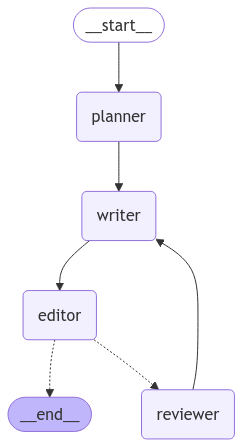

In [59]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [61]:
# Estado inicial
# Inicializar o estado
initial_state = {
    'topic': 'escreva um blog sobre AI',
    'planned': '', 
    'writing': '',     
    'reflect': [],
    'accepted': False,
    'revision': 0,
    'max_revision': 2,
    'tokens': 0
}

# Executar o grafo
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(initial_state, thread):
    pass  # O processamento é feito internamente

# Obter o estado final
final_state = graph.get_state(thread)
print('\n\n')
print(f"Total tokens usados: {final_state.values['tokens']}")  
print('############## Estado Final ############')
print(final_state.values['writing'])

############## planner_node ############
**Título do Blog: Desmistificando a Inteligência Artificial: O Que Você Precisa Saber**

**Introdução**
- Breve definição de Inteligência Artificial (IA)
- Importância da IA na sociedade contemporânea
- Objetivo do blog: esclarecer conceitos, aplicações e tendências

**Seção 1: O que é Inteligência Artificial?**
- História da IA: desde Alan Turing até os dias atuais
- Diferença entre IA fraca e IA forte
- Principais áreas da IA: aprendizado de máquina, processamento de linguagem natural, visão computacional, etc.

**Seção 2: Como a IA está mudando o mundo**
- Exemplos de aplicações de IA em diferentes setores:
  - Saúde: diagnósticos, pesquisa de medicamentos
  - Finanças: análise preditiva, detecção de fraudes
  - Varejo: personalização de compras, gestão de estoque
  - Transporte: veículos autônomos, otimização de rotas
- Discussão sobre o impacto social e econômico da IA

**Seção 3: Desafios e considerações éticas**
- Questões de privacidade 